In [75]:
import typing
import numpy as np
import cv2 as cv
import os, json
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from numba import jit, njit
from sklearn import metrics

cv.setRNGSeed(42)

import logging

numba_logger = logging.getLogger("numba")
numba_logger.setLevel(logging.WARNING)

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [38]:
RUN_EXAMPLES = True


class StopExecution(Exception):
    def _render_traceback_(self):
        pass


class Example:
    def __init__(self) -> None:
        if not RUN_EXAMPLES:
            raise StopExecution


# use the example class like so, to only execute following code if RUN_EXAMPLES = True
Example()
print("only show this when RUN_EXAMPLES = True")

only show this when RUN_EXAMPLES = True


# Function Definitions and Examples

In the first half of this notebook we present some helpful functions that we later use in our processing pipeline

## ProcessImageConfig

to process the image, we use an **ProcessImageConfig**, which contains information about what the 4 colors are in the image approximately:
- cell_color: e.g. black
- background_color: e.g. purple
- marker1_color: e.g. red
- marker2_color: e.g. green

Alternatively these can be obtained by performing clustering, maybe meanshift?

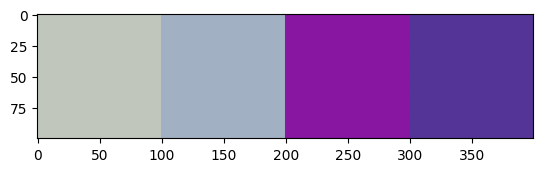

In [39]:
ColorF = Tuple[float, float, float]
ColorI = Tuple[float, float, float]
# as rgb floats [0.0 to 1.0]


@dataclass
class ProcessImageConfig:
    """all values in HSL integers"""

    background_color: ColorF
    cell_color: ColorF
    marker1_color: ColorF
    marker2_color: ColorF

    def show(self):
        im = np.zeros((100, 400, 3), np.float32)
        im[:, :100, :] = self.background_color
        im[:, 100:200, :] = self.cell_color
        im[:, 200:300, :] = self.marker1_color
        im[:, 300:, :] = self.marker2_color
        plt.imshow(im)
        plt.show()

    @staticmethod
    def from_ints(
        background_color: ColorI,
        cell_color: ColorI,
        marker1_color: ColorI,
        marker2_color: ColorI,
    ):
        x = lambda c: (float(c[0]) / 255.0, float(c[1]) / 255.0, float(c[2]) / 255.0)
        return ProcessImageConfig(
            background_color=x(background_color),
            cell_color=x(cell_color),
            marker1_color=x(marker1_color),
            marker2_color=x(marker2_color),
        )


def infer_config_from_image(image: cv.Mat) -> ProcessImageConfig:
    raise "not implemented"  # type: ignore


DISH1_CONFIG = ProcessImageConfig.from_ints(
    background_color=(193, 198, 189),
    cell_color=(161, 176, 194),
    marker1_color=(136, 22, 161),
    marker2_color=(84, 52, 151),
)
Example()
DISH1_CONFIG.show()

## Preprocessing
(encompasses all things that do not need any ProcessImageConfig values)

1. blurring the image to get rid of noise

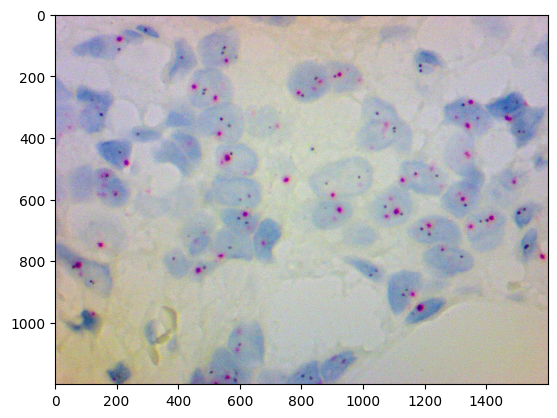

In [40]:
DEBUG = False

def imread(path: str) -> cv.Mat:
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.normalize(img, img, 0, 1, cv.NORM_MINMAX, cv.CV_32F)
    return img


def imshow(img: cv.Mat, debug=False) -> None:
    if not DEBUG and debug:
        return
    if img.shape.__len__() == 3:
        plt.imshow(img)
        plt.show()
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_GRAY2RGB))
        plt.show()


Example()

img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
imshow(img)

## Finding the cell/background separation

The next step is to make a distinction between cells and background.

For this we can calculate the distance from every pixels color to cell color vs. background color. The closest distance decides if this is black in the mask (background) or white (cells)

C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\1152693657.py:8: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fore_ground_soft_mask" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\1152693657.py (12)

File "C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\1152693657.py", line 12:
def fore_ground_soft_mask(
    <source elided>
) -> cv.Mat:
    output = img.copy()[:, :, 0]
    ^

  @jit
C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\1152693657.py:8: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fore_ground_soft_mask" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\1152693657.py", line 32:
def fore_ground_soft_mask(
    <source elided>

    for i in range(height):
    ^

  

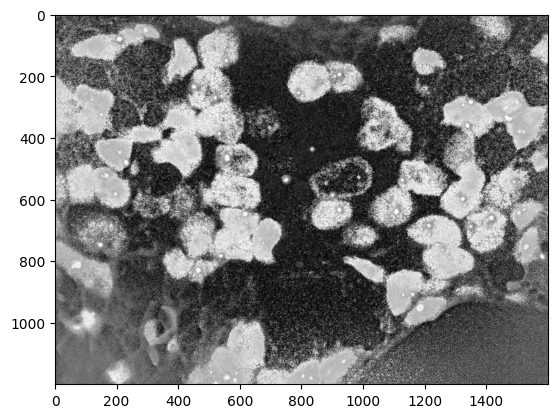

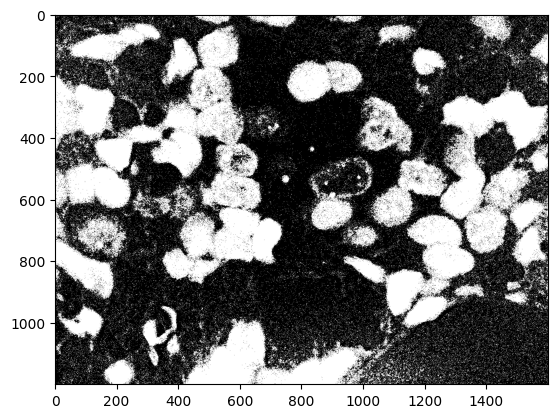

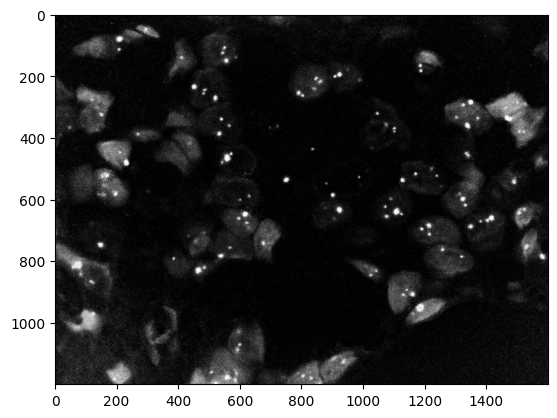

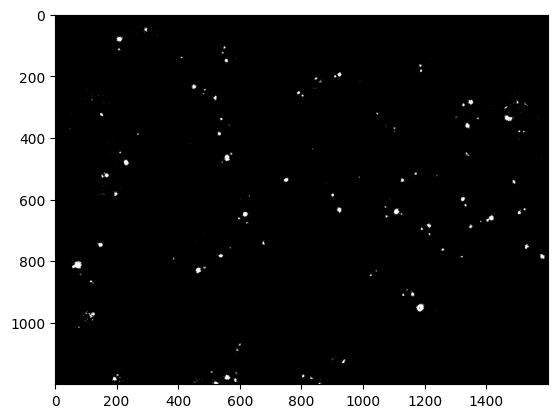

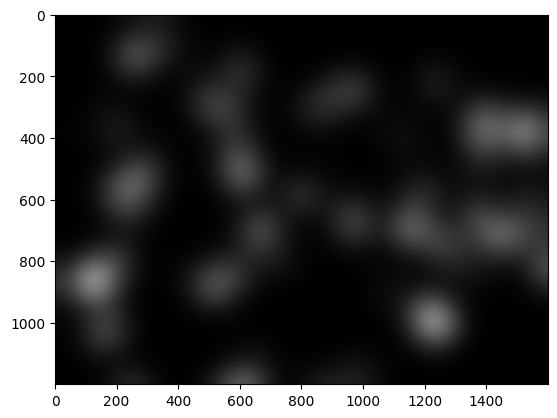

In [41]:
@njit(inline="always")
def rgbsqrdist(
    r1: float, g1: float, b1: float, r2: float, g2: float, b2: float
) -> float:
    return (r1 - r2) * (r1 - r2) + (b1 - b2) * (b1 - b2) + (g1 - g2) * (g1 - g2)


@jit
def fore_ground_soft_mask(
    img: cv.Mat, config: ProcessImageConfig, bg_mul=1.0
) -> cv.Mat:
    output = img.copy()[:, :, 0]
    output[:, :] = 0
    height, width = img.shape[0], img.shape[1]

    bg_r = config.background_color[0]
    bg_g = config.background_color[1]
    bg_b = config.background_color[2]

    cell_r = config.cell_color[0]
    cell_g = config.cell_color[1]
    cell_b = config.cell_color[2]

    m1_r = config.marker1_color[0]
    m1_g = config.marker1_color[1]
    m1_b = config.marker1_color[2]

    m2_r = config.marker2_color[0]
    m2_g = config.marker2_color[1]
    m2_b = config.marker2_color[2]

    for i in range(height):
        for j in range(width):
            r = img[i, j, 0]
            g = img[i, j, 1]
            b = img[i, j, 2]
            bg_dist = rgbsqrdist(r, g, b, bg_r, bg_g, bg_b) * bg_mul
            cell_dist = rgbsqrdist(r, g, b, cell_r, cell_g, cell_b)
            m1_dist = rgbsqrdist(r, g, b, m1_r, m1_g, m1_b)
            m2_dist = rgbsqrdist(r, g, b, m2_r, m2_g, m2_b)

            cell_dist = min(cell_dist, m1_dist, m2_dist)

            output[i, j] = bg_dist / (bg_dist + cell_dist)
    return output


@jit
def versus_soft_mask(img: cv.Mat, black: ColorF, white: ColorF) -> cv.Mat:
    output = img.copy()[:, :, 0]
    output[:, :] = 0
    height, width = img.shape[0], img.shape[1]

    black_r = black[0]
    black_g = black[1]
    black_b = black[2]

    white_r = white[0]
    white_g = white[1]
    white_b = white[2]

    for i in range(height):
        for j in range(width):
            r = img[i, j, 0]
            b = img[i, j, 2]
            g = img[i, j, 1]
            black_dist = rgbsqrdist(r, g, b, black_r, black_g, black_b)
            white_dist = rgbsqrdist(r, g, b, white_r, white_g, white_b)

            output[i, j] = black_dist / (black_dist + white_dist)
    return output


def threshold(img: cv.Mat, thresh: float) -> cv.Mat:
    value, mat = cv.threshold(img, thresh, 1.0, cv.THRESH_BINARY)
    return mat


def multiblur(
    img: cv.Mat,
    iterations: int = 100,
    boost: float = 1.03,
    size: Tuple[int, int] = (20, 20),
):
    img = img
    for i in range(iterations):
        img = cv.blur(img, size) * boost
    return img


# def vs_mask(img: cv.Mat, black: ColorF, white: ColorF):


Example()

img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
config = DISH1_CONFIG
mask = fore_ground_soft_mask(img, config)
imshow(mask)
mask = threshold(mask, 0.5)
imshow(mask)

markers = versus_soft_mask(img, config.background_color, config.marker1_color)
imshow(markers)

markers = threshold(markers, 0.8)
imshow(markers)

blurred_markers = multiblur(markers)
imshow(blurred_markers)

## Autodetermining the config colors

the goal is to extract the relevant colors from the image without setting them manually. This has two steps:

1. cluster image using k-means to get about 10 most dominant colors
2. use agglomerative clustering, to merge the two closest clusters, until just 4 colors remain

centers shape (14, 3)
hist_weights shape (14,)
K 14


C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\2314616686.py:117: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "avg_color_of_mask" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(list(array(float32, 1d, C))<iv=None>)
 
There are 4 candidate implementations:
      - Of which 4 did not match due to:
      Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 129.
        With argument(s): '(list(array(float32, 1d, C))<iv=None>)':
       Rejected as the implementation raised a specific error:
         TypingError: array(float32, 1d, C) not allowed in a homogeneous sequence
  raised from c:\python\lib\site-packages\numba\core\typing\npydecl.py:488

During: resolving callee type: Function(<built-in function array>)
During: typing of call at C:\Users\tadeo\AppData\Local\Temp\ipykernel_33300\23146166

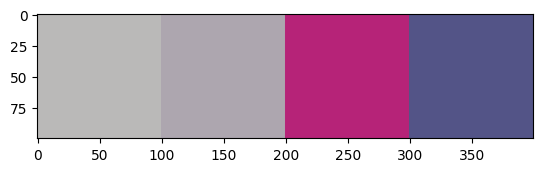

centers shape (14, 3)
hist_weights shape (14,)
K 14


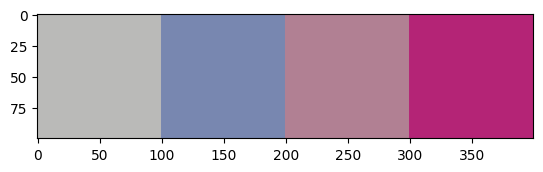

In [77]:
# def auto_determine_config()

from typing import Any


def agglom_cluster(
    centers: np.ndarray, hist_weights: np.ndarray, target_K=4
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Hierarchical Agglomerative Clustering, merging two clusters with closest average distance

    args:
        centers: np 2d array Kx3 with the rgb centers as floats
        hist_weights: (K) float array with normalized hist bin for each cluster
        target_K: how many clusters should remain in the end

    returns:
        index mapping from old class labels to label of new centers
        new centers
        new weights
    """
    print("centers shape", centers.shape)
    print("hist_weights shape", hist_weights.shape)

    # center, weight, indexes merged
    K = len(centers)
    print("K", K)
    clusters = [(centers[i, :], hist_weights[i], {i}) for i in range(K)]
    for _ in range(K - target_K):
        # find min dist between two clusters:
        c1, c2, m = -1, -1, 10000000
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                diff = np.subtract(clusters[i][0], clusters[j][0])
                dist = np.sum(np.multiply(diff, diff))
                if dist < m:
                    c1, c2, m = i, j, dist
        # perform merge:
        w1 = clusters[c1][1]
        w2 = clusters[c2][1]
        w = w1 + w2
        cen = (w1 * clusters[c1][0] + w2 * clusters[c2][0]) / w
        newcluster = [cen, w, clusters[c1][2] | clusters[c2][2]]
        del clusters[c2]
        del clusters[c1]
        clusters.append(newcluster)  # type: ignore

    index_mapping = []
    for i in range(K):
        good = False
        for j in range(len(clusters)):
            if i in clusters[j][2]:
                index_mapping.append(j)
                good = True
                break
        if not good:
            raise Exception(f"Error. At least one cluster should contain {i}")

    return (
        np.array(index_mapping),
        np.array([e[0] for e in clusters]),
        np.array([e[1] for e in clusters]),
    )


def k_means_cluster_image(
    image: cv.Mat, K=10
) -> Tuple[np.ndarray, np.ndarray, cv.Mat, cv.Mat]:
    image = cv.blur(image, (3, 3))
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)  # type: ignore
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, K, 1.0)
    ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_PP_CENTERS)
    label = label.flatten()
    center = np.float32(center)
    res = center[label]  # type: ignore
    img_clustered = res.reshape((image.shape))  # type: ignore
    hist = np.histogram(label, bins=[e for e in range(K + 1)])[0]
    hist = hist / np.sum(hist)
    return hist, center, img_clustered, label  # type: ignore


def autodetermine_config(image: cv.Mat, kmeans_K=14):
    hist, centers, img_clustered, labels = k_means_cluster_image(image, K=kmeans_K)
    index_mapping, new_centers, new_hist = agglom_cluster(centers, hist, target_K=4)
    # sort the hist to determine which of the 4 colors is which:
    hist_args_sorted = np.argsort(new_hist)
    dest = lambda x: (x[0], x[1], x[2])
    marker2_color = dest(new_centers[hist_args_sorted[0]])
    marker1_color = dest(new_centers[hist_args_sorted[1]])
    cell_color = dest(new_centers[hist_args_sorted[2]])
    background_color = dest(new_centers[hist_args_sorted[3]])
    config = ProcessImageConfig(
        background_color, cell_color, marker1_color, marker2_color
    )
    # new_labels = index_mapping[labels]
    # print(new_labels)
    # res = new_centers[new_labels]
    # img_clustered = res.reshape((image.shape))
    # imshow(img_clustered)
    return config


# because we sometimes have trouble determining the cell color: we can try something else:
# we know that we can almost always get marker1_color and marker2_color reliably.
# determine the autoconfig as usual, but then to get the average color of marker1_color and marker2_color and set this as the cell color


def neighborhood(image: cv.Mat, size: int = 50) -> cv.Mat:
    """image should be bw mask with float values 0.0 - 1.0"""
    blurred = cv.GaussianBlur(image, (size + 1, size + 1), 10)
    direct_neighbor = threshold(blurred, 0.2)
    far_neighbor = threshold(blurred, 0.001)
    return np.subtract(far_neighbor, direct_neighbor)


@jit
def avg_color_of_mask(image: cv.Mat, mask: cv.Mat):
    masked_image = image.copy()
    masked_image[:, :, 0] = np.multiply(image[:, :, 0], mask)
    masked_image[:, :, 1] = np.multiply(image[:, :, 1], mask)
    masked_image[:, :, 2] = np.multiply(image[:, :, 2], mask)
    h, w = mask.shape
    vec = []
    i: int = 0
    while i < h:
        j: int = 0
        while j < w:
            if mask[i, j] == 1.0:
                vec.append(masked_image[i, j, :])
            j += 1
        i += 1
    vec = np.array(vec)
    return np.mean(vec, axis=0)


def autodetermine_config_marker_surrounding_approach(image: cv.Mat, kmeans_K=14):
    hist, centers, img_clustered, labels = k_means_cluster_image(image, K=kmeans_K)
    index_mapping, new_centers, new_hist = agglom_cluster(centers, hist, target_K=4)
    # sort the hist to determine which of the 4 colors is which:
    hist_args_sorted = np.argsort(new_hist)
    dest = lambda x: (x[0], x[1], x[2])
    marker2_color = dest(new_centers[hist_args_sorted[0]])
    marker1_color = dest(new_centers[hist_args_sorted[1]])
    cell_color = dest(new_centers[hist_args_sorted[2]])
    background_color = dest(new_centers[hist_args_sorted[3]])
    new_labels = index_mapping[labels]
    res = new_centers[new_labels]
    img_clustered = res.reshape((image.shape))

    marker1_mask = threshold(
        versus_soft_mask(image, background_color, marker1_color), 0.7
    )
    marker1_neighborhood = neighborhood(marker1_mask)
    avg_color_marker1_neighborhood = avg_color_of_mask(image, marker1_neighborhood)
    config = ProcessImageConfig(
        background_color, avg_color_marker1_neighborhood, marker1_color, marker2_color
    )

    marker2_mask = threshold(
        versus_soft_mask(image, background_color, marker2_color), 0.7
    )
    marker2_neighborhood = neighborhood(marker2_mask)
    avg_color_marker2_neighborhood = avg_color_of_mask(image, marker2_neighborhood)

    avg_neighborcolor = (
        avg_color_marker2_neighborhood + avg_color_marker1_neighborhood
    ) / 2
    config = ProcessImageConfig(
        background_color, avg_neighborcolor, marker1_color, marker2_color
    )

    return config


Example()


# print("Agglomerative merging example:")
# centers = np.array(
#     [
#         [1, 1, 1],
#         [1, 1, 1],
#         [4.2, 3.4, 5.8],
#         [4.5, 3.4, 5.6],
#         [1.1, 1, 1.3],
#         [0.0, 0.1, 1.3],
#     ],
#     np.float32,
# )
# print(centers)

# agglom = agglom_cluster(centers, np.array([0.2, 0.2, 0.2, 0.1, 0.1, 0.2]), target_K=3)
# print(agglom, "\n-------------------------------\n")

# first approach:

# print("extract image example: ")
# img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
# # img = imread("data/sampleinput/FISH/12-09-12P0012201890-2.jpg")
# conf = autodetermine_config(img, 4)
# conf.show()

# second approach with surrounding:

conf = autodetermine_config_marker_surrounding_approach(img)
conf.show()

conf = autodetermine_config(img)
conf.show()

# Defining our processing pipeline

## Evaluation

In [43]:
from typing import Any
from shapely.geometry import Polygon, Point, MultiPoint


class AnnotationPoly:
    """A polygon from a list of points"""

    points: List[Tuple[float, float]]
    _polygon: Polygon
    center: Tuple[float, float]
    area: float
    # (y, x) points of the surrounding
    def __init__(self, points: List[Tuple[float, float]]) -> None:
        self.points = points
        self._polygon = Polygon(self.points)

        center_point: Point = self._polygon.centroid
        self.center = (center_point.x, center_point.y)
        self.area = self._polygon.area

    @staticmethod
    def from_json(json: Dict[str, Any]):
        xes = [float(s) for s in json["Points"][0]["X"].split(",")]
        yes = [float(s) for s in json["Points"][0]["Y"].split(",")]
        return AnnotationPoly([(x, y) for (x, y) in zip(xes, yes)])

    def bounds_size(self) -> Tuple[float, float]:
        """returns (height,width) of the area enclosed"""
        minx, miny, maxx, maxy = self._polygon.bounds
        return (maxy - miny, maxx - minx)

    def bounds_avg_size(self):
        h, w = self.bounds_size()
        return (h + w) / 2

    def contains_point(self, point: Tuple[float, float]):
        return Point(point[1], point[0]).within(self._polygon)
        # self._polygon.within()

    def resize(self, resize_factor: float):
        new_points = [(y * resize_factor, x * resize_factor) for (y, x) in self.points]
        return AnnotationPoly(new_points)


class SampleImage:
    processed: None | cv.Mat
    image: cv.Mat

    def __init__(self, partial_path: str) -> None:
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        self.image = imread(jpg_path)


class LabelInformation:
    annotations: List[AnnotationPoly]
    name: str
    image_size: Tuple[int, int]  # (h, w)
    image: cv.Mat

    def __init__(self, partial_path: str) -> None:
        """expects partial_path to be like: "DISH1/125121A_S20200928_0014"
        - looks for data/reference/DISH1/125121A_S20200928_0014/ndmctsgh.json
        - looks for data/sampleinput/DISH1/125121A_S20200928_0014.jpg
        """
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        json_path = f"data/reference/{partial_path}/ndmctsgh.json"
        self.name = partial_path

        # read metadata from json
        f = open(json_path)
        j = json.load(f)
        f.close()
        annotations = []
        for a in j["annotations"]:
            annotations.append(AnnotationPoly.from_json(a))
        self.annotations = annotations

        # jpg_path = f"data/sampleinput/{partial_path}.jpg"
        # image = imread(jpg_path)
        # self.image_size = (image.shape[0], image.shape[1])
        # self.image = self.draw_annotations()

        label_image_path = f"data/reference/{partial_path}/label_image.jpg"
        self.image = imread(label_image_path)[:, :, 0]

    def draw_annotations(self) -> cv.Mat:
        output = np.zeros(self.image_size, np.float32)
        for a in self.annotations:
            points = np.array([point for point in a.points], np.int32)
            output = cv.fillPoly(output, pts=[points], color=(255, 255, 255))
            plt.imshow(output)
        return output

In [44]:
from sklearn import metrics


def confusion_from_images(
    labeled: cv.Mat, predicted_soft: cv.Mat, threshold: float = 0.5
):
    predicted_hard = np.where(predicted_soft > threshold, 1, 0)  # type: ignore
    labeled_hard = np.where(labeled > threshold, 1, 0)  # type: ignore
    conf = metrics.confusion_matrix(np.ravel(labeled_hard), np.ravel(predicted_hard))
    return conf / np.sum(conf)


def confusion_matrix_to_tuples(confusion_matrix: np.ndarray):
    tp = confusion_matrix[1, 1]
    fp = confusion_matrix[0, 1]
    tn = confusion_matrix[0, 0]
    fn = confusion_matrix[1, 0]


def plot_confusion_matrix(confusion_matrix):
    metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot(
        cmap="coolwarm"
    )
    plt.show()


def visualize_predictions(
    labeled: cv.Mat, predicted_soft: cv.Mat, threshold: float = 0.5
):
    output = np.zeros((labeled.shape[0], labeled.shape[1], 3), np.float32)
    output[:, :, 1] = labeled
    output[:, :, 2] = predicted_soft
    output[:, :, 0] = np.where(
        (output[:, :, 1] == 1.0) & (output[:, :, 2] == 1.0), 1.0, 0.0
    )
    imshow(output)

In [45]:
all_partial_paths = [
    # "TEST/test"
    "DISH1/125121A_S20200928_0014",
    "DISH1/125121A_S20200928_0017",
    "DISH1/1931427A_S20200928_0005",
    "DISH1/1931427A_S20200928_0014",
    "DISH1/2004994A_S20201013_0001",
    "DISH2/1(2)",
    "DISH2/5(2)",
    "DISH2/DISH3",
    "DISH2/P002120277A-2",
    "DISH2/P002124864A-1",
    "FISH/12-09-12P0012201890-2",
    "FISH/12-09-12P0012201893-1",
    "FISH/12-09-13P001220195-1",
    "FISH/P001506473(P001805365A)-1",
    "FISH/P001531546(P001529027C)9",
]

labels: Dict[str, LabelInformation] = {
    p: LabelInformation(p) for p in all_partial_paths
}

# for (p, l) in labels.items():
#     cv.imwrite(f"data/reference/{p}/label_image.jpg", l.image)

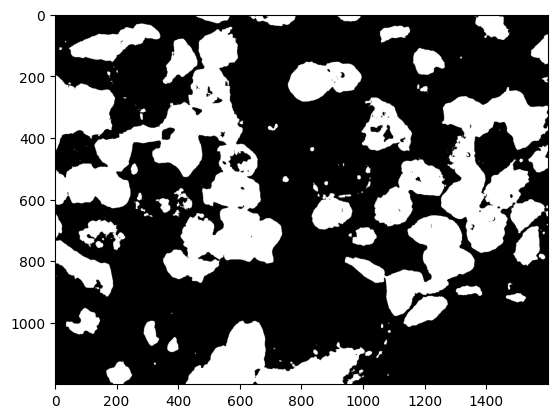

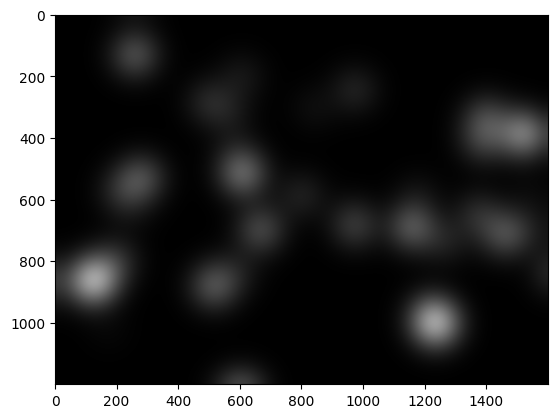

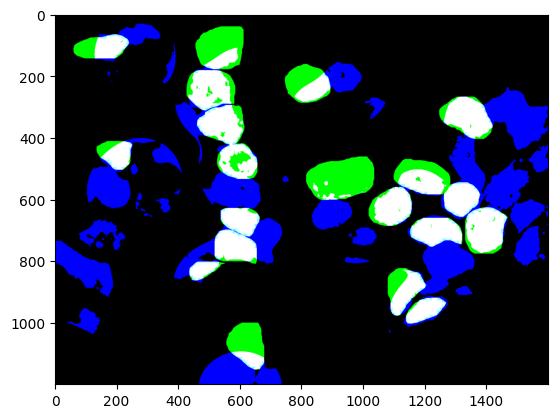

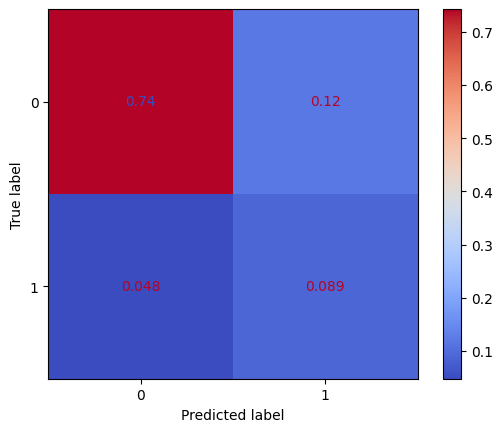

In [46]:
def process_image(img: cv.Mat, config: ProcessImageConfig):
    """gets a f32 rgb image and a processing config as input and produces a mask image that reflects the classification result"""
    img = cv.blur(img, (10, 10))
    # separate foreground and background:
    cells = fore_ground_soft_mask(img, config)
    cells = threshold(cells, 0.6)

    imshow(cells)
    markers1 = versus_soft_mask(img, config.background_color, config.marker1_color)
    markers1 = threshold(markers1, 0.9)
    markers1 = multiblur(markers1, iterations=100, boost=1.025, size=(20, 20))

    markers2 = versus_soft_mask(img, config.background_color, config.marker2_color)
    markers2 = threshold(markers2, 0.6)
    markers2 = multiblur(markers2, iterations=100, boost=1.025, size=(20, 20))

    markers = np.minimum(markers1, markers2) * 3
    imshow(markers)

    cells_with_markers = np.minimum(cells, markers)
    cells_with_markers = threshold(cells_with_markers, 0.02)
    return cells_with_markers


def process_and_evaluate_image(partial_path: str, process):
    label_information = labels[partial_path]
    sample_image = SampleImage(partial_path)
    # config = autodetermine_config(sample_image.image, 15)
    # config.show()
    processed: cv.Mat = process(sample_image.image, DISH1_CONFIG)
    label_image = label_information.image
    confusion = confusion_from_images(label_image, processed, 0.5)
    visualize_predictions(label_image, processed, 0.02)
    plot_confusion_matrix(confusion)


Example()

process_and_evaluate_image(all_partial_paths[0], process_image_bg_only)

## Autodetermine Config for all images:

for all images check if the autodetermined config looks okay:

auto config for DISH1/125121A_S20200928_0014
(10, 3)
img_clustered


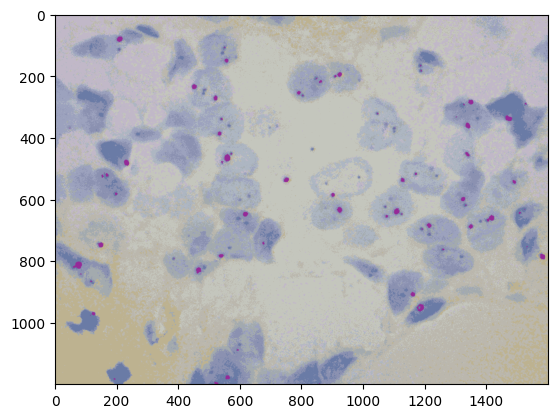

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


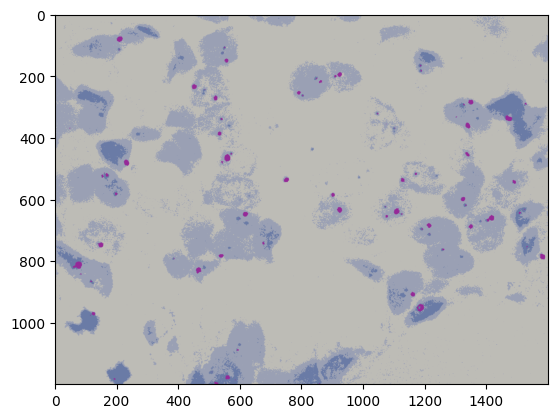

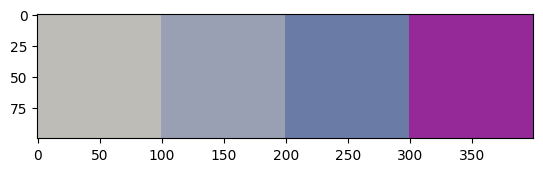

auto config for DISH1/125121A_S20200928_0017
(10, 3)
img_clustered


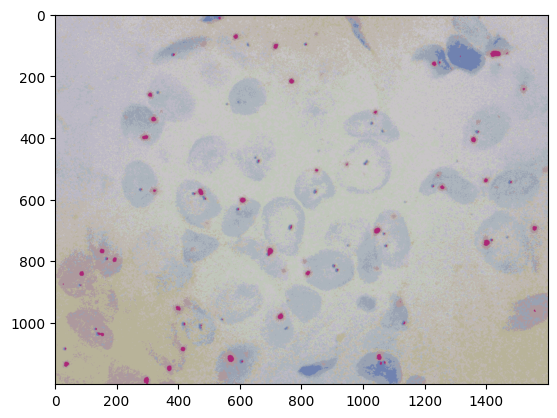

centers shape (10, 3)
hist_weights shape (10,)
K 10
[2 2 2 ... 3 3 2]


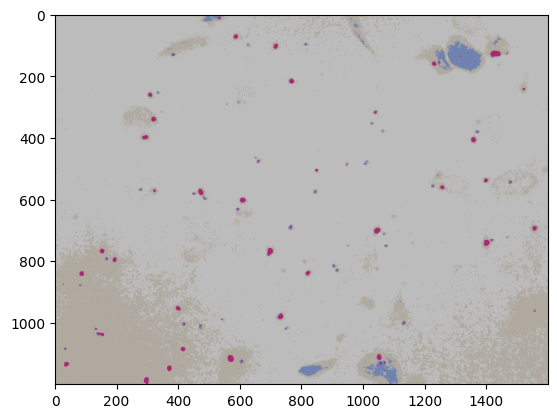

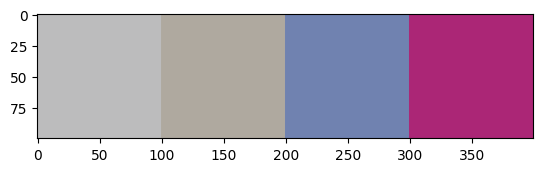

auto config for DISH1/1931427A_S20200928_0005
(10, 3)
img_clustered


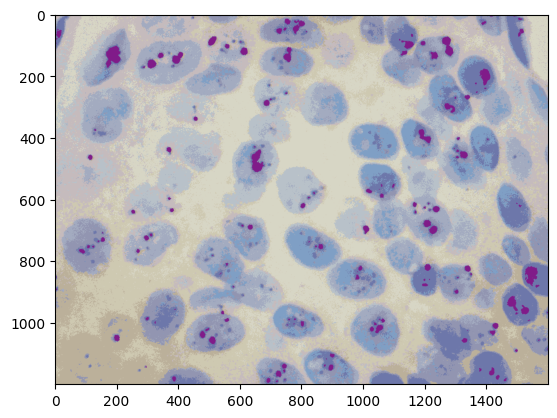

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


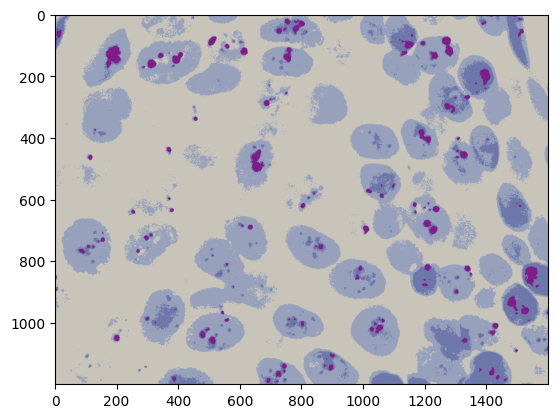

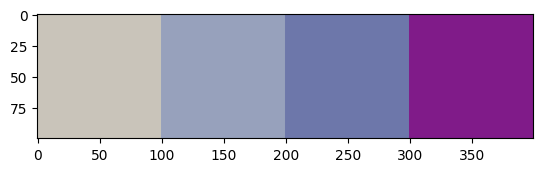

auto config for DISH1/1931427A_S20200928_0014
(10, 3)
img_clustered


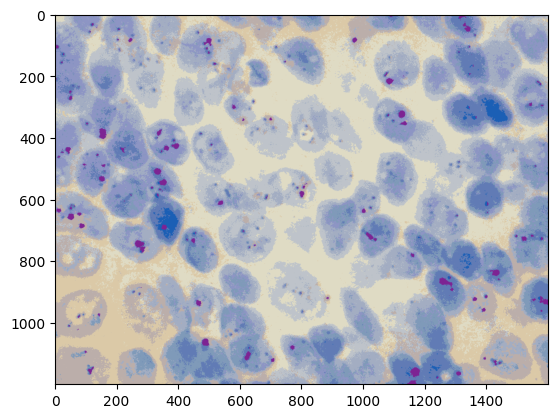

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


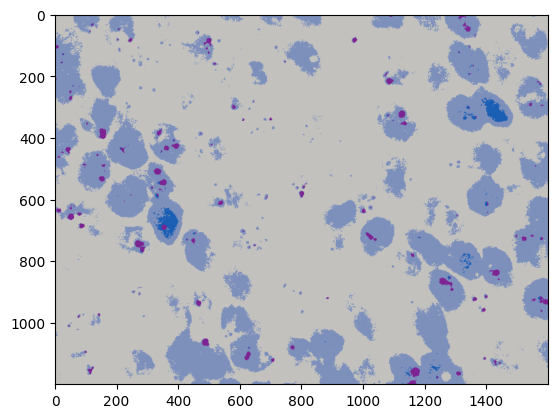

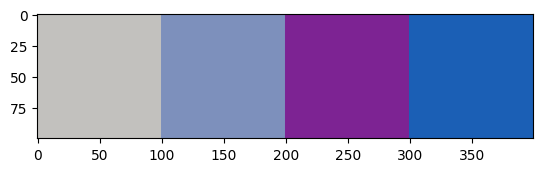

auto config for DISH1/2004994A_S20201013_0001
(10, 3)
img_clustered


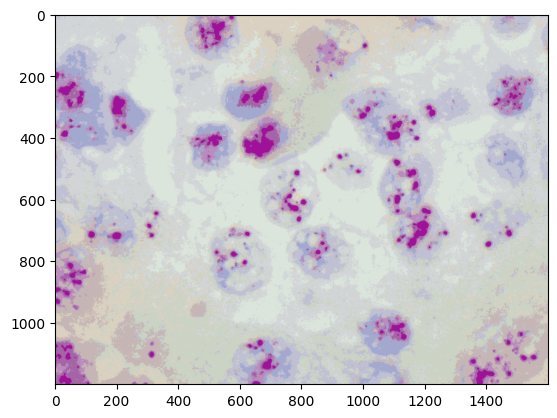

centers shape (10, 3)
hist_weights shape (10,)
K 10
[2 2 2 ... 2 3 3]


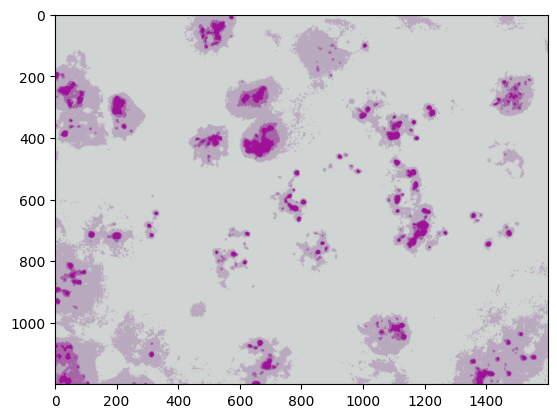

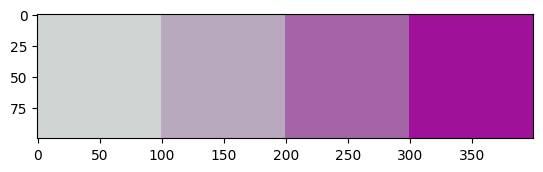

auto config for DISH2/1(2)
(10, 3)
img_clustered


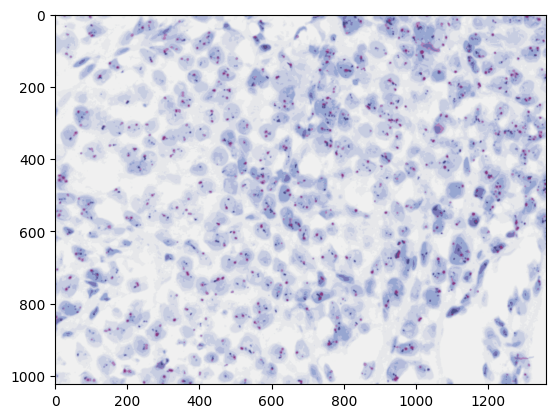

centers shape (10, 3)
hist_weights shape (10,)
K 10
[1 1 1 ... 1 1 1]


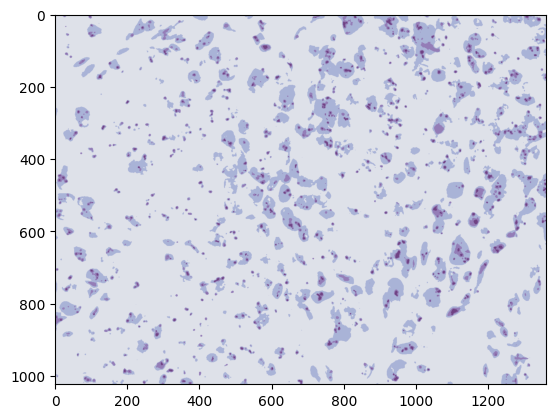

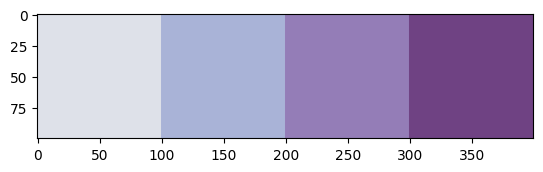

auto config for DISH2/5(2)
(10, 3)
img_clustered


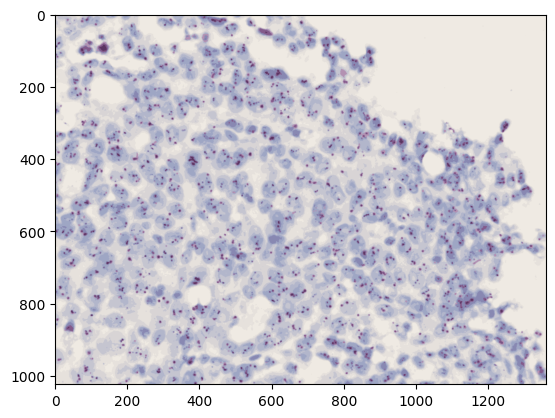

centers shape (10, 3)
hist_weights shape (10,)
K 10
[2 2 2 ... 2 2 2]


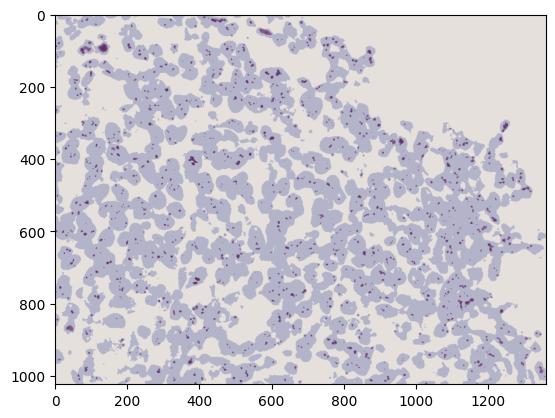

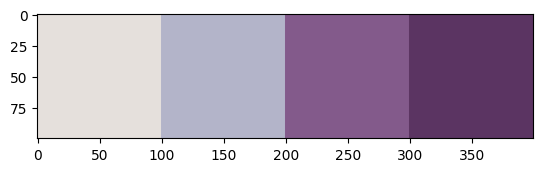

auto config for DISH2/DISH3
(10, 3)
img_clustered


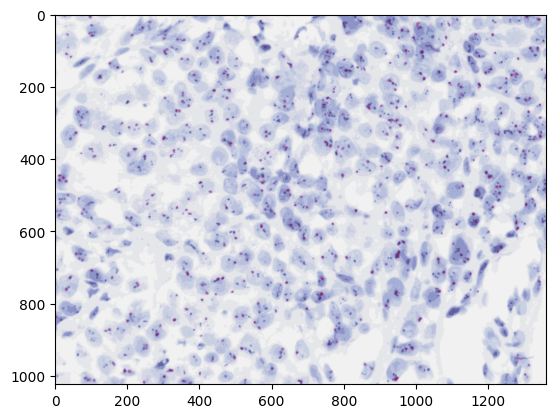

centers shape (10, 3)
hist_weights shape (10,)
K 10
[1 1 1 ... 1 1 1]


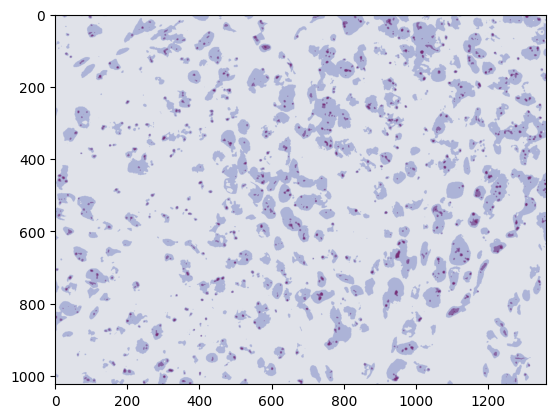

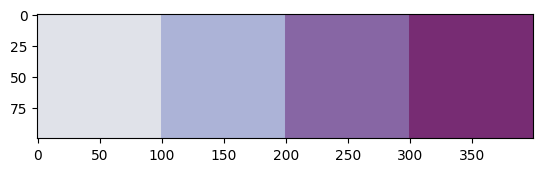

auto config for DISH2/P002120277A-2
(10, 3)
img_clustered


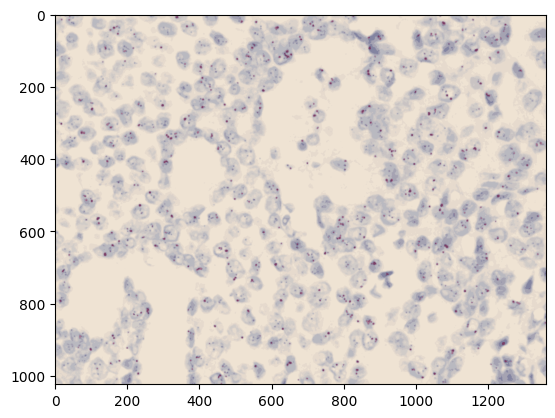

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


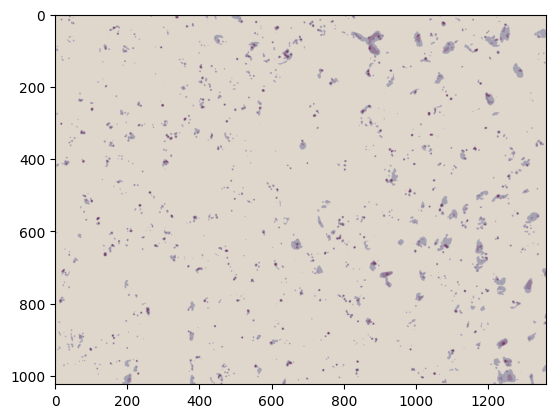

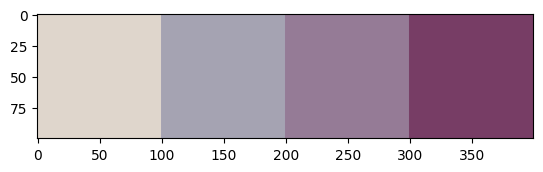

auto config for DISH2/P002124864A-1
(10, 3)
img_clustered


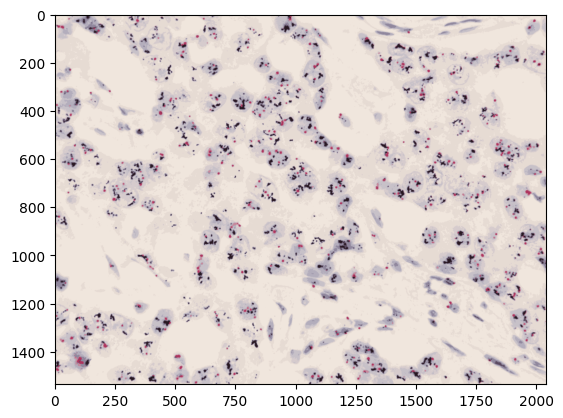

centers shape (10, 3)
hist_weights shape (10,)
K 10
[1 1 1 ... 1 1 1]


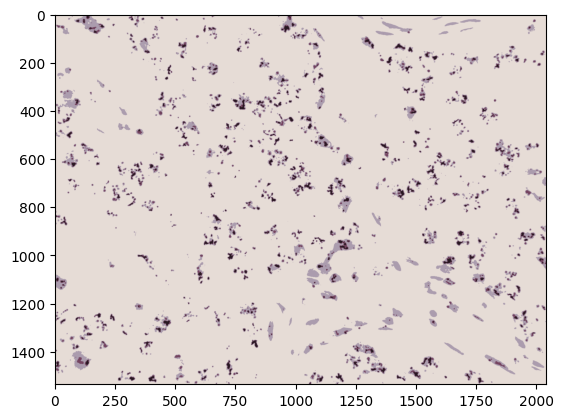

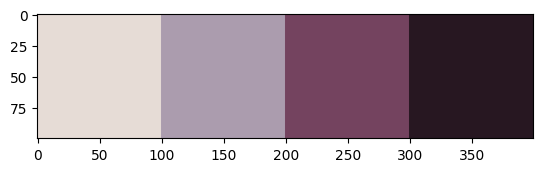

auto config for FISH/12-09-12P0012201890-2
(10, 3)
img_clustered


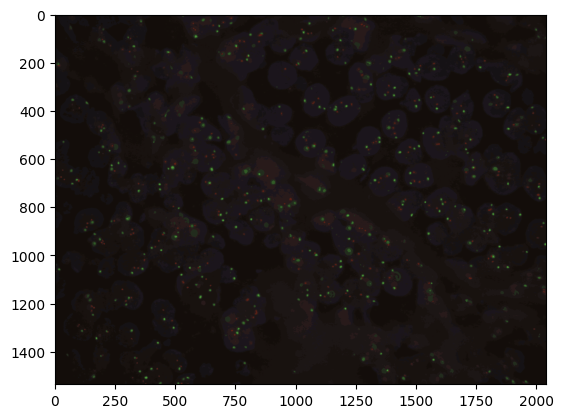

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


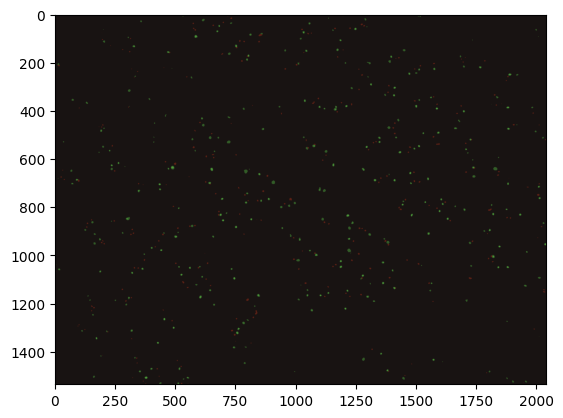

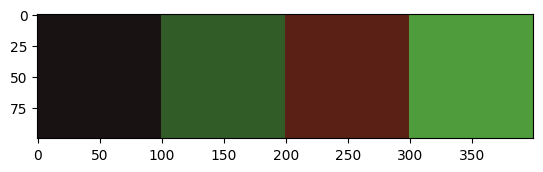

auto config for FISH/12-09-12P0012201893-1
(10, 3)
img_clustered


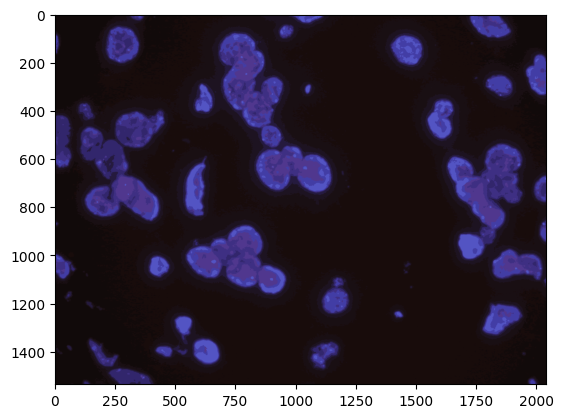

centers shape (10, 3)
hist_weights shape (10,)
K 10
[2 2 2 ... 2 2 2]


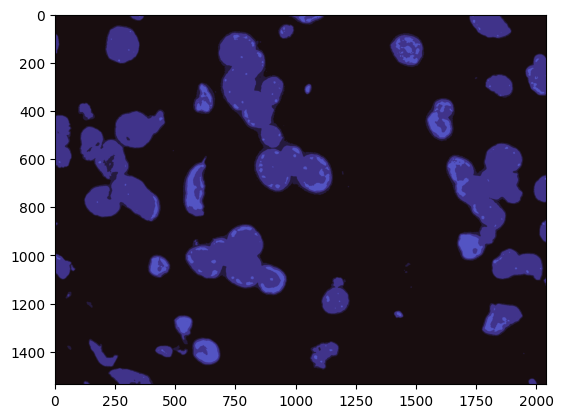

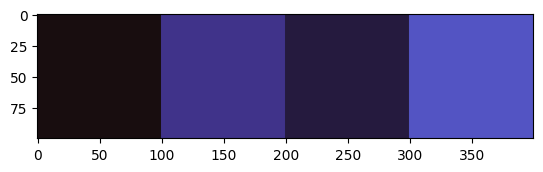

auto config for FISH/12-09-13P001220195-1
(10, 3)
img_clustered


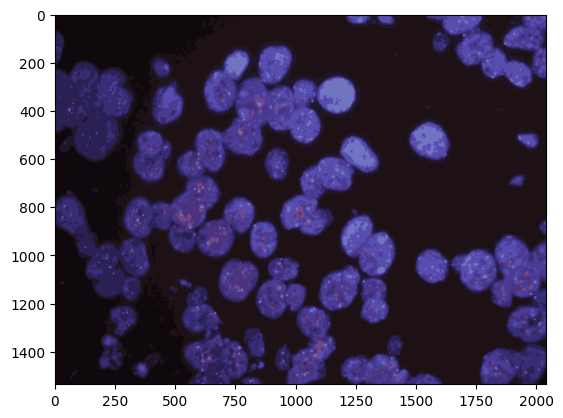

centers shape (10, 3)
hist_weights shape (10,)
K 10
[1 1 1 ... 1 1 1]


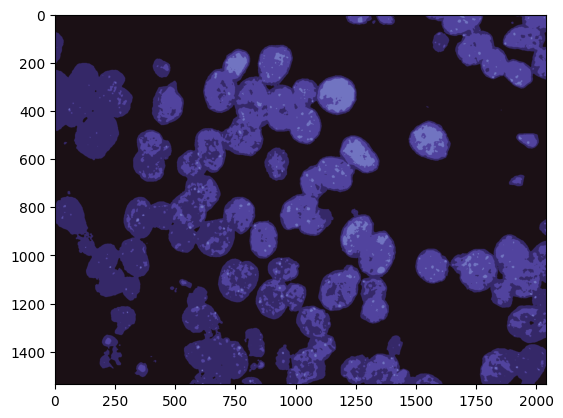

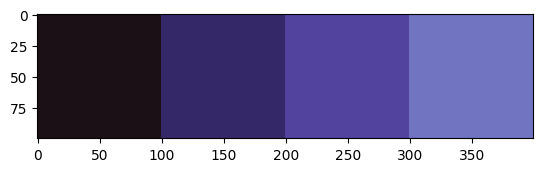

auto config for FISH/P001506473(P001805365A)-1
(10, 3)
img_clustered


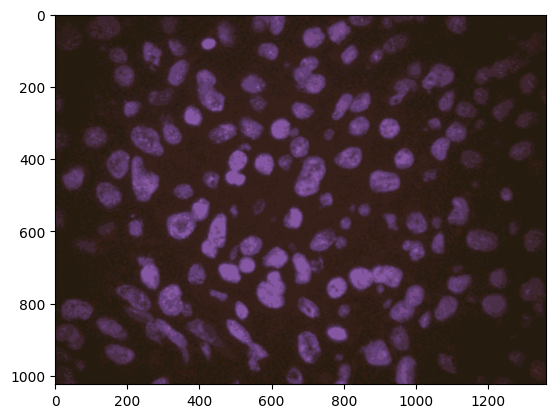

centers shape (10, 3)
hist_weights shape (10,)
K 10
[3 3 3 ... 3 3 3]


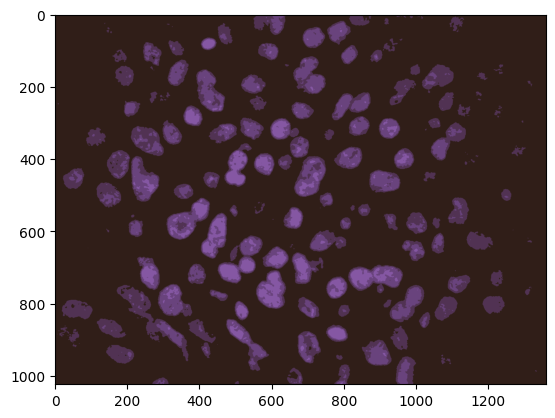

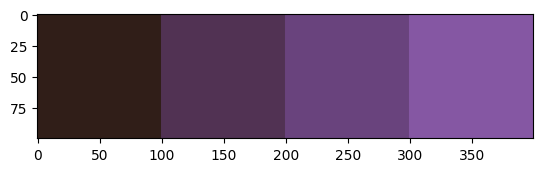

auto config for FISH/P001531546(P001529027C)9
(10, 3)
img_clustered


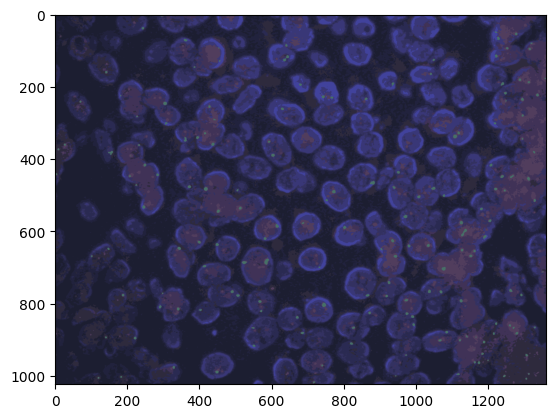

centers shape (10, 3)
hist_weights shape (10,)
K 10
[2 2 2 ... 2 2 2]


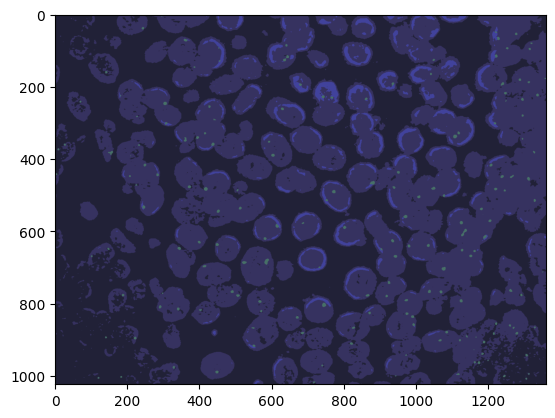

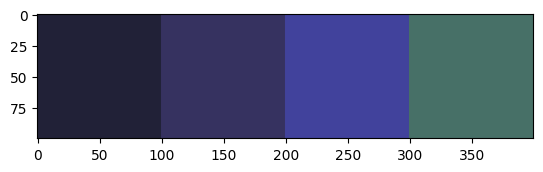

In [47]:
for partial_path in all_partial_paths:
    print(f"auto config for {partial_path}")
    img = SampleImage(partial_path).image
    config = autodetermine_config(img, kmeans_K=10)
    config.show()

(4, 3)


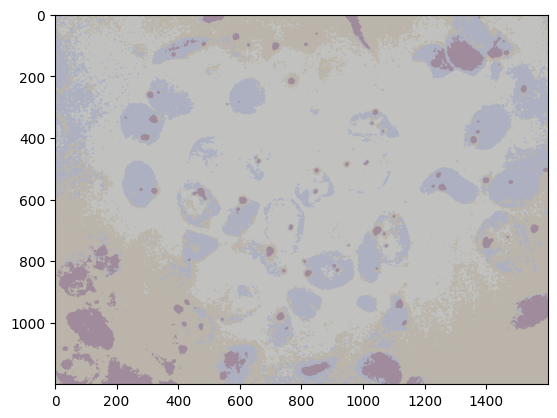

In [48]:
img = SampleImage(all_partial_paths[1]).image

img = cv.blur(img, (5, 5))
_, _, clus, _ = k_means_cluster_image(img, 4)
imshow(clus)
# gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
# gray255 = (gray * 255).astype("uint8")  # type: ignore
# thresh, img = cv.threshold(gray255, 0, 255, cv.THRESH_TOZERO)
# imshow(img)
# # imshow(img)
# #
# # bin = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
# # # imshow(img)
# # cv.threshold(img,)